In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, mean_squared_error


df = pd.read_csv("insurance.csv")


In [117]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [118]:

print("Total Rows:", df.shape[0])
print("Total Columns:", df.shape[1])

Total Rows: 1338
Total Columns: 7


In [119]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [120]:

df.isnull().sum().sort_values(ascending=False)

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [121]:
X_raw = df.drop("charges", axis=1)
y_raw = df["charges"]
X_temp = X_raw.copy()
le = LabelEncoder()
for col in ['sex', 'smoker', 'region']:
    X_temp[col] = le.fit_transform(X_temp[col])


X_train, X_test, y_train, y_test = train_test_split(X_temp, y_raw, test_size=0.2, random_state=0)

raw_model = LinearRegression()
raw_model.fit(X_train, y_train)
y_pred_raw = raw_model.predict(X_test)
r2_before = r2_score(y_test, y_pred_raw)
print('Linear Regression before')
print(f'R2: {r2_before}')

Linear Regression before
R2: 0.7998747145449959


In [122]:
df['bmi*age'] = df['bmi'] * df['age']
df['age*smoker'] = df['bmi'] * df['children']
print(df[['bmi*age','age*smoker']].head())

   bmi*age  age*smoker
0  530.100        0.00
1  607.860       33.77
2  924.000       99.00
3  749.265        0.00
4  924.160        0.00


In [123]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    median_val = df[col].median()
    df[col].fillna(median_val)
    print(f"Filled missing values in {col} with median: {median_val}")

categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val)
    print(f"Filled missing values in {col} with mode: {mode_val}")

Filled missing values in age with median: 39.0
Filled missing values in bmi with median: 30.4
Filled missing values in children with median: 1.0
Filled missing values in charges with median: 9382.033
Filled missing values in bmi*age with median: 1152.225
Filled missing values in age*smoker with median: 27.36
Filled missing values in sex with mode: male
Filled missing values in smoker with mode: no
Filled missing values in region with mode: southeast


In [124]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    original_size = df.shape[0]
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    removed = original_size - df.shape[0]
    print(f"{removed} outliers removed from '{col}'")
    return df

for col in ['age', 'charges', 'bmi']:
    df = remove_outliers_iqr(df, col)

0 outliers removed from 'age'
139 outliers removed from 'charges'
13 outliers removed from 'bmi'


In [125]:
X = df.drop("charges", axis=1)
y = df["charges"]

X_n = X.select_dtypes(include=['number'])
mi_scores = pd.Series(mutual_info_regression(X_n, y), index=X_n.columns).sort_values(ascending=False)

top_features = mi_scores.head(3).index.tolist()
X_selected = df[top_features]
print("Top Features:", top_features)

Top Features: ['age', 'bmi*age', 'children']


In [126]:

X = X.copy()
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))
target='age'
numeric_df = df.select_dtypes(include=['number'])
correlation = numeric_df.corr()[target].abs().sort_values(ascending=False)

X_numeric = X.select_dtypes(include=['number'])
mutual_info = pd.Series(mutual_info_regression(X_numeric, y), index=X_numeric.columns)
mutual_info = mutual_info.sort_values(ascending=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lr = LinearRegression()
lr.fit(X_train, y_train)
preds_lr = lr.predict(X_test)

r2_lr = r2_score(y_test, preds_lr)
mse_lr = mean_squared_error(y_test, preds_lr)

print('Linear Regression after')
print('R²: ',r2_lr)
print('MSE:' ,mse_lr)


Linear Regression after
R²:  0.5813516083201127
MSE: 23236649.689450745


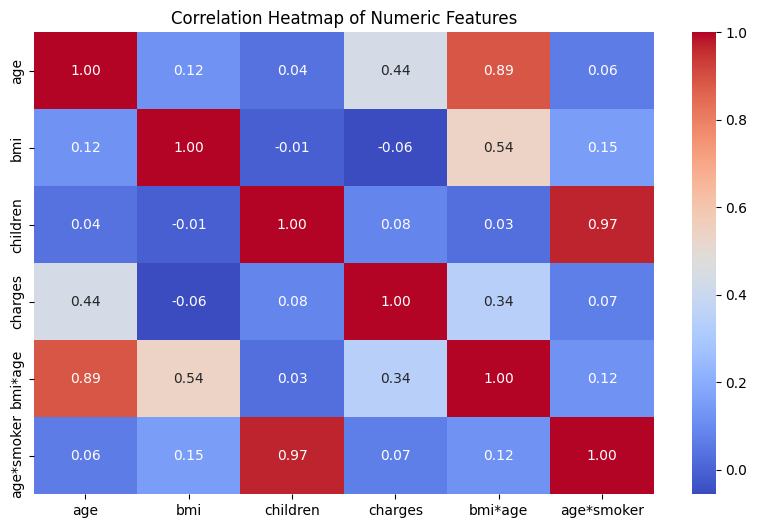

In [127]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()